In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [22]:
%matplotlib inline

import pandas as pd
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from sklearn import decomposition

np.set_printoptions(suppress=True)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [164]:
# s1 = selected_009266[:4]
# s2 = selected_009266[-5:]
# selected = s1 + s2  # sessions that have GLM AEP unit fits
# selected
session = selected_009266[0]
session

'009266_hippoSIT_2023-04-17_17-04-17'

In [171]:
session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
aeps_events = session_data['aeps_events']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']

## Build GLM fit params matrix

In [165]:
animal = session.split('_')[0]
aeps_pop_file = os.path.join(source, animal, session, 'AEPs_pop.h5')

# get number of units / AEP metrics
with h5py.File(aeps_pop_file, 'r') as f:
    metrics_count = len([grp for grp in f])
    for grp in f:
        unit_count = np.array(f[grp]['glm_fit_params']).shape[0] - 1
        break

# retrieve GLM fit matrix
AEP_targets = ['P1', 'N1', 'P2', 'P3']  # ensure order
glm_mx = np.zeros([unit_count, metrics_count])
with h5py.File(aeps_pop_file, 'r') as f:
    for i, grp in enumerate(AEP_targets):
        if not grp in f:
            continue
        glm_mx[:, i] = np.array(f[grp]['glm_fit_params'])[1:]  # don't forget first is intercept

## Reconstruct AEPs - 1: linear comb of individual micro- response profiles

In [169]:
# for 51 bins = 10ms bins
bin_idxs = {
    'P1': np.array([0, 1, 2]),
    'N1': np.array([3, 4, 5, 6, 7]),
    'P2': np.array([8, 9, 10]),
    'P3': np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
}

for key, val in bin_idxs.items():
    bin_idxs[key] = np.concatenate([val, val + 25])

In [170]:
def get_transform_vector(bin_idxs, glm_coeffs, length=50):
    """
    glm_coeffs - 4 coeffs given P1, N1, P2, P3
    psth - 50x array of spiking profile
    bin_idxs - indexes of bins to apply transform coeffs
    """
    AEP_targets = ['P1', 'N1', 'P2', 'P3']  # ensure order
    t_vector = np.zeros(length)
    
    for i, metric in enumerate(AEP_targets):
        t_vector[bin_idxs[metric]] = glm_coeffs[i]
    return t_vector

In [172]:
hw, bc = 0.25, 51
sel_units = [unit_name for unit_name in unit_names if int(unit_name[0]) < 3]

psths = np.zeros([len(sel_units), bc - 1])
for i, unit_name in enumerate(sel_units):  # note BGR only
    bins, psths[i] = get_spike_counts(spike_times[unit_name], aeps_events[aeps_events[:, 1] == 1][:, 0], hw, bc)

(-0.25, 0.25)

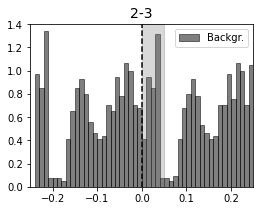

In [174]:
# plot any PSTH
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(bins[1:], bins=bins, weights=psths[10], edgecolor='black', color='black', alpha=0.5, label='Backgr.')
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.set_title(unit_name, fontsize=14)
ax.legend(loc='upper right', prop={'size': 10})
ax.set_xlim(-hw, hw)

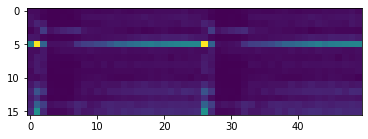

In [175]:
plt.imshow(psths)

In [176]:
# build transform vector matrix
t_vec_mx = np.zeros([len(sel_units), bc - 1])

for i, glm_coeffs in enumerate(glm_mx):
    t_vec_mx[i] = get_transform_vector(bin_idxs, glm_coeffs)

(-0.25, 0.25)

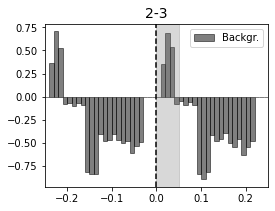

In [177]:
idx = 2
counts_scaled = psths[idx] * t_vec_mx[idx]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(bins[1:], bins=bins, weights=counts_scaled, edgecolor='black', color='black', alpha=0.5, label='Backgr.')
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.set_title(unit_name, fontsize=14)
ax.legend(loc='upper right', prop={'size': 10})
ax.set_xlim(-hw, hw)

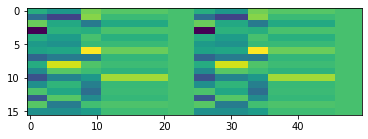

In [178]:
plt.imshow(t_vec_mx)

(-0.25, 0.25)

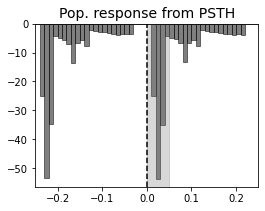

In [179]:
profile = (psths * t_vec_mx).sum(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(bins[1:], bins=bins, weights=profile, edgecolor='black', color='black', alpha=0.5)
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.set_title('Pop. response from PSTH', fontsize=14)
ax.set_xlim(-hw, hw)

## Reconstruct AEPs 2: population responses to individual AEPs

In [196]:
hw, bc = 0.25, 51
sel_units = [unit_name for unit_name in unit_names if int(unit_name[0]) < 3]

bins = np.linspace(-hw, hw, bc)
pulse_times = aeps_events[aeps_events[:, 1] == 1][:, 0]  # Note BGR only

# population responses to each AEP
pop_resp_mx = np.zeros([len(pulse_times), bc - 1])
for i, t_pulse in enumerate(pulse_times):
    curr_pop_resp = np.zeros([len(sel_units), bc - 1])
    for j, unit in enumerate(sel_units):
        spk_times = spike_times[unit]
        p_spikes  = spk_times[(spk_times > t_pulse - hw) & (spk_times < t_pulse + hw)]
        counts, _ = np.histogram(p_spikes - t_pulse, bins=bins)
        curr_pop_resp[j] = counts
        
    # multiply (or not) by transformation matrix with GLM coeffs
    curr_pop_resp = curr_pop_resp * t_vec_mx
    pop_resp_mx[i] = curr_pop_resp.sum(axis=0) / len(sel_units)

(-0.25, 0.25)

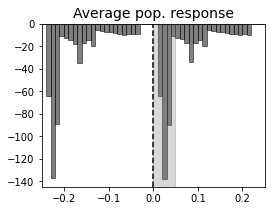

In [197]:
profile = pop_resp_mx.sum(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(bins[1:], bins=bins, weights=profile, edgecolor='black', color='black', alpha=0.5)
ax.axvline(0, color='black', ls='--')
ax.axvspan(0, 0.05, alpha=0.3, color='gray')
ax.set_title('Average pop. response', fontsize=14)
ax.set_xlim(-hw, hw)

In [ ]:
# maybe multiply each unit response by GLM fit

In [ ]:
#     for grp in f:
#         collected[grp] = {}
#         collected[grp]['corr_glm_fit_orig'] = np.array(f[grp]['corr_glm_fit_orig'])
#         collected[grp]['glm_fit_params']    = np.array(f[grp]['glm_fit_params'])
#         collected[grp]['glm_fit_pvalues']   = np.array(f[grp]['glm_fit_pvalues'])
#         collected[grp]['corr_glm_fit_shuf'] = np.array(f[grp]['corr_glm_fit_shuf'])
#         collected[grp]['corr_glm_fit_chun'] = np.array(f[grp]['corr_glm_fit_chun'])